<h1><center>We're going to cover a standard PyTorch workflow as follows:</center></h1>
<center><img src="source_images/workflow.png" width=900 height=300/></center>

# Libraries

In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import os

# Set model target device (mps for GPU on apple devices)
device = torch.device('mps')

# Create data

In [2]:
# Create objective variables (Target)
weights = 0.7
bias = 0.3

# Make up vars 
start = 0
end = 1
step = 0.02

# unsqueeze(dim=1): Returns a new tensor with a dimension of size one inserted at the specified position
X = torch.arange(start, end, step, device='mps').unsqueeze(dim=1)
y = weights * X + bias

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
# Function to plot the predictions
def plot_predictions(
        train_data=X_train.to(torch.device('cpu')),
        train_labels=y_train.to(torch.device('cpu')),
        test_data=X_test.to(torch.device('cpu')),
        test_labels=y_test.to(torch.device('cpu')),
        predictions=None):
    """
    Plot and compare predictions
    """
    plt.figure(figsize=(10,7))

    # Plot scatters: Train data
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    # Plot scatters: Test data
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')
    # Plot scatters: Predictions
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    
    # Show legend
    plt.legend(prop={'size':14});

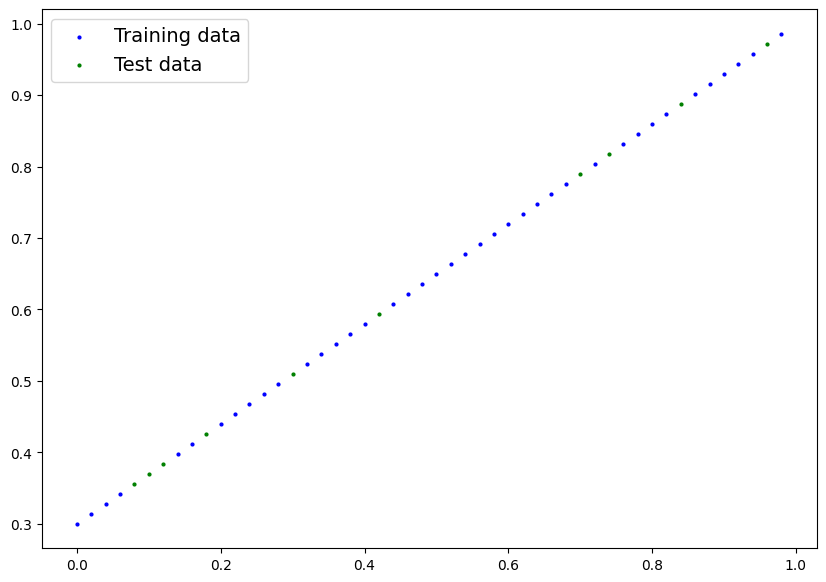

In [4]:
plot_predictions()

# Setup model config

<center><img src="source_images/pytorch_classes.png" width=900 height=400/></center>

> *The figure represents the basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects within the subclass `nn.Module`, the `forward()` method must be defined*

Where:
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
* `torch.optim` contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

* `torch.rand()`: Returns a tensor filled with random numbers from a uniform distribution on the interval [0,1)   
* `torch.rand().requires_grad` : If autograd should record operations on the returned tensor

In [5]:
# Create a class for a linear model (Large version)
class LinearRegressionModel(nn.Module): # All pytorch models inherit from nn.Module
    # Constructor to Inicialize parameters
    def __init__(self): 
        # Initialize parent class parameters
        super().__init__()
        # Initialize model parameters
        self.weights = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))

    # forward() method to compute the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias  # Lineal regression function

<h3><center><code>nn.linear</code> compared to <code>nn.parameter</code>:</center></h3>
<center><img src="source_images/nn_linear.png" width=900 height=400/></center>

In [69]:
# Create a class for a linear model (Pytorch version)
class LinearRegressionModel(nn.Module): # All pytorch models inherit from nn.Module
    # Constructor to Inicialize parameters
    def __init__(self):
        # Initialize parent class parameters
        super().__init__()
        # Initialize model parameters: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # forward() method to compute the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)  # Lineal regression function

In [70]:
# Set seed for reproducibility
torch.manual_seed(42) 
model1 = LinearRegressionModel() # Instanciate and Initialize model class
model1, model1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [71]:
model1.to(device)
next(model1.parameters()).device

device(type='mps', index=0)

# Training and testing model (All together)
<center><img src="source_images/training_loop.png" width=1000 height=500/></center>

<center><img src="source_images/testing_loop.png" width=1000 height=500/></center>

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [72]:
# Setup Loss function: 
# nn.L1Loss(): Creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y
loss_fn = nn.L1Loss()

# Setup optimizer
# torch.optim.SGD(): Implements stochastic gradient descent
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.01)

In [73]:
# Training testing loop

# Setup empty lists to keep track of the model progress
epoch_count = []
train_loss_values = []
test_loss_values = []

epochs = 200
torch.manual_seed(42) 
for epoch in range(epochs):

    # ==================================================================TRAINING==================================================================

    # model1.train() (Bool): Set the object in training mode: 
    # This has any effect only on certain modules. See documentations of particular modules for details of their behaviors in training/evaluation mode,
    # if they are affected, e.g. Dropout, BatchNorm, etc.
    model1.train()

    # 1. Forward pass: Apply linear regression formula
    y_pred = model1(X_train)

    # 2. Calculate the loss: MAE over predictions and labels
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad: Sets the gradients of all optimized torch.Tensor s to zero.
    optimizer.zero_grad()

    # 4. Backwards pass: Performs backwards propagation
    loss.backward()

    # 5. Optimizer step: Update optimizer values
    optimizer.step()

    # ==================================================================TESTING==================================================================

    # model1.eval() (Bool): Set the object in evaluation mode:
    # This has any effect only on certain modules. See documentations of particular modules for details of their behaviors in training/evaluation mode,
    # if they are affected, e.g. Dropout, BatchNorm, etc.
    model1.eval()

    with torch.inference_mode():
        test_pred = model1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.cpu().detach().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
        print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

Epoch: 0 | Loss: 0.5623740553855896 | Test loss: 0.5464363694190979
Epoch: 10 | Loss: 0.43722376227378845 | Test loss: 0.42416977882385254
Epoch: 20 | Loss: 0.31207355856895447 | Test loss: 0.30190321803092957
Epoch: 30 | Loss: 0.18692336976528168 | Test loss: 0.1796366423368454
Epoch: 40 | Loss: 0.0619397833943367 | Test loss: 0.06097868084907532
Epoch: 50 | Loss: 0.03458136320114136 | Test loss: 0.04493854567408562
Epoch: 60 | Loss: 0.030024951323866844 | Test loss: 0.03902362659573555
Epoch: 70 | Loss: 0.025658756494522095 | Test loss: 0.03323739022016525
Epoch: 80 | Loss: 0.021291932091116905 | Test loss: 0.027494041249155998
Epoch: 90 | Loss: 0.016924751922488213 | Test loss: 0.021750692278146744
Epoch: 100 | Loss: 0.012558934278786182 | Test loss: 0.015964437276124954
Epoch: 110 | Loss: 0.00819174014031887 | Test loss: 0.010221093893051147
Epoch: 120 | Loss: 0.0038403065409511328 | Test loss: 0.004481789655983448
Epoch: 130 | Loss: 0.008938628248870373 | Test loss: 0.003912618849

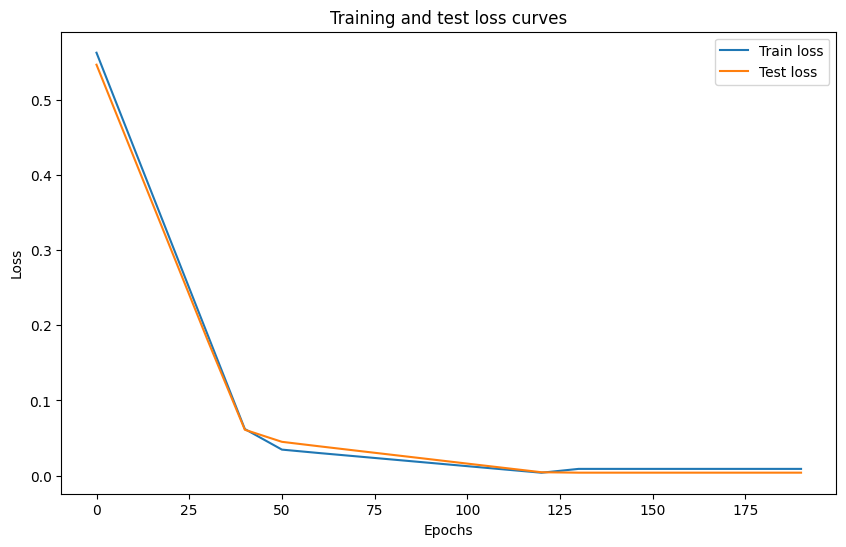

In [74]:
# Plot the loss curves
plt.figure(figsize=(10,6))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

# Make evaluations and predictions

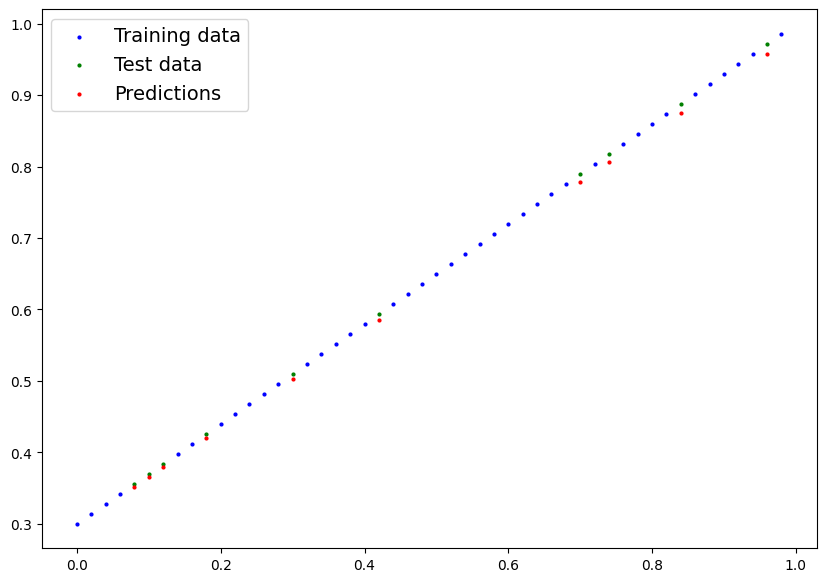

In [75]:
# Turn model into evaluation mode
model1.eval()

# Evaluations
with torch.inference_mode():
    y_pred = model1(X_test).cpu() # Convert to cpu to plot in Numpy arrays

# Plot predictions
plot_predictions(predictions = y_pred)

# Saving the trained model

In [76]:
# Set folder and model name
folder_name = '../models'
model_name = 'LinearRegressionModel.pth'

# .pth: typically contains a serialized PyTorch state dictionary that contains the state of a PyTorch model, including the model's weights, biases, 
# and other parameters.

# Create folder if does not exist
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

# Define path and save model state parameters
model_path = os.path.join(folder_name, model_name)
torch.save(obj=model1.state_dict(), f=model_path)

# Loading the trained model

In [77]:
# Load the pytorch model

# Create a new instance of the model
load_model1 = LinearRegressionModel()

# Load model state
state_dict = torch.load(model_path)

# Update model parameters
load_model1.load_state_dict(state_dict)

# Put the loaded model to device (mps)
load_model1.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [78]:
load_model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6891]], device='mps:0')),
             ('linear_layer.bias', tensor([0.2965], device='mps:0'))])